In [1]:
import os
import numpy as np
from glob import glob
import scipy.stats
from astropy import units as u
from astropy.io import fits
from astropy.stats import sigma_clip, sigma_clipped_stats
import astropy.coordinates as coord
from astropy.coordinates import SkyCoord
from astropy.time import Time
from astroquery.vizier import Vizier
from astropy import wcs
import photutils
from astropy.cosmology import FlatLambdaCDM


%matplotlib inline
import matplotlib.pyplot as plt

# change plotting defaults
plt.rc('axes', labelsize=14)
plt.rc('axes', labelweight='bold')
plt.rc('axes', titlesize=16)
plt.rc('axes', titleweight='bold')
plt.rc('font', family='sans-serif')
plt.rcParams['errorbar.capsize'] = 3
opts = {'mec':'k', 'mew': 0.5, 'lw': 1}
plt.rcParams['figure.figsize'] = (14, 10)

Files obtained here:
* https://data.sdss.org/datamodel/files/
* Left column links lead to html directory on information of the files, right column links lead to file directory of all the fits files.

Testing data from SDSS/SPIDERS using the XMMSL2 sample. 
* Official SDSS-DR16 Value Added Catalogues: https://data.sdss.org/sas/dr16/eboss/spiders/analysis/VAC_SPIDERS_XMMSL2_DR16.fits
* Official data model, description of the columns: https://data.sdss.org/datamodel/files/SPIDERS_ANALYSIS/VAC_spiders_XMMSL2_DR16.html

Multi-wavelength characterization of the XMM-Slew2 Survey point-like sources (Boller et al. 2016) over the DR16+SEQUELS footprints. We provide information about X-ray properties of the sources, as well as their Gaia DR2 optical counterparts, FIRST radio counterparts and AllWISE IR counterparts. The counterparts are identified first in the All-WISE IR catalog via a Bayesian cross-matching algorithm, NWAY (Salvato et al 2018). We complement this with dedicated visual inspection of the SDSS spectra, providing accurate redshift estimates (with objective confidence levels) and source classification, beyond the standard eBOSS pipeline results. 


Information on obtaining FITS table data: https://docs.astropy.org/en/stable/io/fits/usage/table.html

In [2]:
XMMSL2_hdu =fits.open('VAC_SPIDERS_XMMSL2_DR16.fits')
XMMSL2_data = XMMSL2_hdu[1].data #image data
XMMSL2_head = XMMSL2_hdu[1].header #header data

In [3]:
XMMSL2_head

XTENSION= 'BINTABLE'           / binary table extension                         
BITPIX  =                    8 / 8-bit bytes                                    
NAXIS   =                    2 / 2-dimensional table                            
NAXIS1  =                  678 / width of table in bytes                        
NAXIS2  =                 3196 / number of rows in table                        
PCOUNT  =                    0 / size of special data area                      
GCOUNT  =                    1 / one data group                                 
TFIELDS =                  128 / number of columns                              
EXTNAME = 'Joined  '           / table name                                     
TTYPE1  = 'XMMSL2_IAU_NAME'    / label for column 1                             
TFORM1  = '40A     '           / format for column 1                            
TTYPE2  = 'XMMSL2_RA'          / label for column 2                             
TFORM2  = 'D       '        

In [4]:
#Spectral classification after Visual Inspection: 
#(QSO/BLAGN: broad-line quasar; BAL_QSO/QSO_BAL: broad absorption line quasar; 
#NLAGN: narrow line AGN; BLAZAR/BLLAC: blazar; GALAXY: galaxy; STAR: star; NONE/UNDET.: unknown)
XMMSL2_data['CLASS_BEST'] 

chararray(['GALAXY', 'BLAGN', 'BLAZAR', ..., '-', 'QSO', 'QSO'],
          dtype='<U8')

NOTE: SDSS is using optical wavelenght, so at times, the emission lines might appear broader. But SPIDERS is designed for X-Ray emissions so their lines likely to be more narrow.

In [5]:
#masked array
mask = np.zeros(np.shape(XMMSL2_data), dtype='bool')
mask2 = np.zeros(np.shape(XMMSL2_data), dtype='bool')

for i in range(len(XMMSL2_data['CLASS_BEST'])):
    if XMMSL2_data['CLASS_BEST'][i]  == 'NLAGN':
        mask[i] = 1
        if XMMSL2_data['DR16_z'][i] <=0.2:
            mask[i] = 1
    if XMMSL2_data['CLASS_BEST'][i]  == 'GALAXY':
        mask2[i] = 1
        if XMMSL2_data['DR16_z'][i] <=0.2:
            mask2[i] = 1

print(np.sum(mask))
print(np.sum(mask2))

21
199


In [6]:
XMMSL2_data[mask]

FITS_rec([('XMMSL2 J234107.0+001835', 355.27962582,  0.30976599, 7.30532662, 26.75464,      nan, 18.90612,  9.853146, 3.26256 ,      nan,      nan,  7.111473, 2.810836, 0., 0., nan, nan,  0.,  0., nan, nan, nan,  7.124448,      nan,  8.760882,  4.3689127, 1.4466283 ,       nan,      nan, 1.1656445 , 0.46072537, 1.383005 , 0.4579387,      nan,       nan, 0.8117302, 0.3208394, 20.53016 , 0., 7.6840216e+02, 0.9993743 , 0.99999654, 'J234106.92+001833.1', 355.2788334,  0.3092176, 0.06116805, 13.205, 0.024, 12.393, 0.025,  9.767, 0.052, 7.557, 0.158, '0000', '5', '110n', 16.19 , 0.148, 15.518, 0.206, 14.503, 0.113, 4874, '301', 4, 389, 276, 355.27872703,  0.30925511, 19.69135 , 18.336256, 17.297512, 16.846498, 16.34685 , 21.822674, 20.742867, 19.743746, 19.303532, 18.752014, 0.40604139, 1, 2, 1, 'DR16',  385, 51783, 487, 0.27671984, 1.4210556e-05, 'GALAXY', 'STARBURST BROADLINE',  0,  9.472567 , 0, 0, 1, 0, 0, 0.277, 2.8017163e-04, 'NLAGN', 3, 355.27879182,  0.30932222, 4.1157001e+02, 4.1981

AllWISE Catalog and Multiepoch Photometry Database magnitudes are given in the Vega system and represent total in-band brightness measurements. 

In [7]:
XMMSL2_data['ALLW_W1mag'][mask]

array([13.205, 13.268, 11.649, 13.906, 12.222, 12.771, 12.753, 11.534,
       12.863, 12.729, 12.321, 14.986, 13.949,  9.436, 12.51 , 13.721,
       14.011, 13.742, 14.54 , 10.482, 13.451], dtype=float32)

https://ui.adsabs.harvard.edu/abs/2018MNRAS.478.3056B/abstract

Information on cutoffs. 

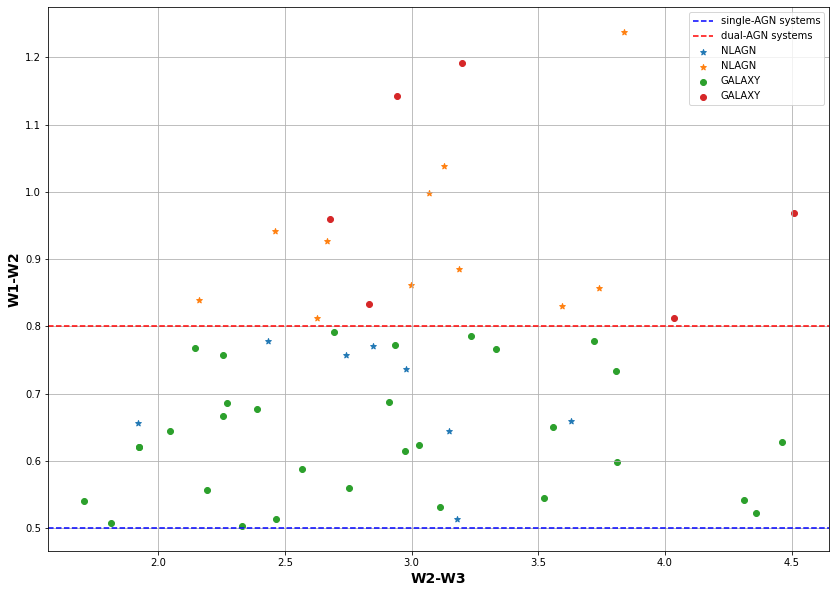

In [8]:
W1_W2 = XMMSL2_data['ALLW_W1mag'][mask] - XMMSL2_data['ALLW_W2mag'][mask] #trying this a truth array to Class - Galaxy
W2_W3 = XMMSL2_data['ALLW_W2mag'][mask] - XMMSL2_data['ALLW_W3mag'][mask]
W1_W2_Galaxy = XMMSL2_data['ALLW_W1mag'][mask2] - XMMSL2_data['ALLW_W2mag'][mask2] 
W2_W3_Galaxy = XMMSL2_data['ALLW_W2mag'][mask2] - XMMSL2_data['ALLW_W3mag'][mask2]
#Filter out to AGN cutoffs
Single1 = (W1_W2 >=0.5) & (W1_W2 <=0.8)
Double1 = W1_W2 >=0.8
Single2 = (W1_W2_Galaxy >=0.5) & (W1_W2_Galaxy <=0.8)
Double2 = W1_W2_Galaxy >=0.8

plt.scatter(W2_W3[Single1], W1_W2[Single1], marker='*', label='NLAGN')
plt.scatter(W2_W3[Double1], W1_W2[Double1],  marker='*', label='NLAGN')
plt.scatter(W2_W3_Galaxy[Single2], W1_W2_Galaxy[Single2], label='GALAXY')
plt.scatter(W2_W3_Galaxy[Double2], W1_W2_Galaxy[Double2], label='GALAXY')

plt.axhline(0.5, ls='--', c='blue', label='single-AGN systems') #
plt.axhline(0.8, ls='--', c='red', label='dual-AGN systems') #
plt.xlabel("W2-W3")
plt.ylabel("W1-W2")
plt.legend()
plt.grid();

In [9]:
for i in range(len((XMMSL2_data[mask]))):
    print(XMMSL2_data[mask]['SDSS_ID'][i], XMMSL2_data[mask]['SDSS_RA'][i], 
          XMMSL2_data[mask]['SDSS_DEC'][i], W1_W2[i], W2_W3[i])

276 355.27872702986605 0.30925511192689337 0.8120003 2.6259995
161 222.79187656948258 49.13710451663365 0.7779999 2.4320002
60 183.9559675021973 54.706663074374774 1.0380001 3.1280003
129 187.25552318016935 38.50669223461232 0.8310003 3.5950003
79 342.1026332704232 0.15574887683682634 0.64400005 3.1490002
23 168.1648678287978 45.69480986377256 0.99800014 3.0689993
12 220.71026375538088 54.88572754498097 0.6590004 3.6289997
57 157.17492673021096 49.071848607398664 0.51399994 3.1800003
121 167.7523530081181 49.32857585629559 0.92700005 2.6680002
154 222.61109747796138 58.66248080791685 0.8859997 3.1880007
189 160.87839785936868 44.45620960205277 0.9420004 2.4609995
144 221.37238654274643 51.3846824536459 0.85700035 3.7410002
182 212.83550489529046 52.20272729054428 0.19799995 2.3770008
94 206.3299179593119 41.71255889196646 0.3260002 2.3249998
117 244.53903840930843 36.332747429317834 0.75699997 2.7400007
210 217.0915425626184 41.60651585433142 1.2379999 3.8400002
76 143.7005374322539 53

Note: Try to find a way to print out the index number so you can narrow down on who's who

In [10]:
#NLAGN targets
for i in range(len((XMMSL2_data[mask]))):
    print(XMMSL2_data[mask]['SDSS_ID'][i], XMMSL2_data[mask]['XMMSL2_IAU_NAME'][i], 
          XMMSL2_data[mask]['PLATE_BEST'][i], XMMSL2_data[mask]['MJD_BEST'][i], XMMSL2_data[mask]['FIBERID_BEST'][i],
          XMMSL2_data[mask]['SDSS_RA'][i], XMMSL2_data[mask]['SDSS_DEC'][i], XMMSL2_data[mask]['DR16_Z'][i])

276 XMMSL2 J234107.0+001835 385 51783 487 355.27872702986605 0.30925511192689337 0.27671984
161 XMMSL2 J145109.0+490814 1048 52736 416 222.79187656948258 49.13710451663365 0.15599924
60 XMMSL2 J121549.3+544226 8214 57867 390 183.9559675021973 54.706663074374774 0.15007865
129 XMMSL2 J122902.0+383034 1992 53466 491 187.25552318016935 38.50669223461232 0.16800107
79 XMMSL2 J224824.8+000930 675 52590 593 342.1026332704232 0.15574887683682634 0.05378426
23 XMMSL2 J111238.5+454135 1438 53054 165 168.1648678287978 45.69480986377256 0.13642386
12 XMMSL2 J144249.6+545309 1162 52668 66 220.71026375538088 54.88572754498097 0.12485466
57 XMMSL2 J102841.8+490425 874 52338 513 157.17492673021096 49.071848607398664 0.042935867
121 XMMSL2 J111100.6+491939 7395 57131 328 167.7523530081181 49.32857585629559 0.23163393
154 XMMSL2 J145026.1+583942 608 52081 1 222.61109747796138 58.66248080791685 0.21028125
189 XMMSL2 J104330.3+442721 1431 52992 24 160.87839785936868 44.45620960205277 0.12764189
144 XMMSL

In [11]:
#J144250.46+5453308.6
a = XMMSL2_data[mask]['SDSS_ID'] == 12
print(XMMSL2_data[mask]['SDSS_ID'][a], XMMSL2_data[mask]['XMMSL2_IAU_NAME'][a], 
          XMMSL2_data[mask]['PLATE_BEST'][a], XMMSL2_data[mask]['MJD_BEST'][a], XMMSL2_data[mask]['FIBERID_BEST'][a],
          XMMSL2_data[mask]['SDSS_RA'][a], XMMSL2_data[mask]['SDSS_DEC'][a], XMMSL2_data[mask]['DR16_Z'][a])

[12] ['XMMSL2 J144249.6+545309'] [1162] [52668] [66] [220.71026376] [54.88572754] [0.12485466]


In [12]:
#GALAXY targets
for i in range(len(XMMSL2_data[mask2])):
    print(XMMSL2_data[mask2]['SDSS_ID'][i], XMMSL2_data[mask2]['XMMSL2_IAU_NAME'][i], 
          XMMSL2_data[mask2]['PLATE_BEST'][i], XMMSL2_data[mask2]['MJD_BEST'][i], XMMSL2_data[mask2]['FIBERID_BEST'][i],
          XMMSL2_data[mask2]['SDSS_RA'][i], XMMSL2_data[mask2]['SDSS_DEC'][i], XMMSL2_data[mask2]['DR16_Z'][i])

351 XMMSL2 J153333.8+455137 8510 57846 184 233.38768375306037 45.860184450668555 0.36594874
15 XMMSL2 J090157.2+600909 1785 54439 615 135.4933094746342 60.151726593380545 0.011133517
166 XMMSL2 J131112.4+322928 2093 53818 286 197.8012169224338 32.48430853315887 0.24009891
314 XMMSL2 J022101.9+044609 4264 55506 765 35.25622481678971 4.770088979908559 0.68248224
454 XMMSL2 J005552.6+262504 7676 57329 643 13.972278569249283 26.4168320582686 0.2584853
56 XMMSL2 J025450.2-024747 7823 56978 181 43.70977090154609 -2.7978747308755687 0.11815202
228 XMMSL2 J091752.8+514331 5730 56607 629 139.4725731945201 51.727042742685185 0.21675691
124 XMMSL2 J114339.7+462137 1444 53054 96 175.91499898854352 46.35567785826985 0.11602518
14 XMMSL2 J121408.8+543142 1019 52707 261 183.54006270798675 54.526646250994254 0.008177739
36 XMMSL2 J120913.6+470332 1449 53116 103 182.30878419196074 47.05835726052896 0.02427534
920 XMMSL2 J024301.4+014339 7821 57279 276 40.75529250512125 1.724005340971684 0.40445352
938 

185 XMMSL2 J013604.3+213719 7634 56935 538 24.016411343316292 21.62347497060414 0.16237919
268 XMMSL2 J014826.0+140237 11052 58438 108 27.1116361159265 14.041839163126427 0.12276431
233 XMMSL2 J073152.5+280435 4456 55537 532 112.96971449376211 28.075809536492002 0.24805048
348 XMMSL2 J091954.6+425655 8283 57064 94 139.97363175205285 42.95034281869802 0.6865627
658 XMMSL2 J105159.0+435408 4690 55653 87 162.99008197061107 43.90474830683865 0.5420611
717 XMMSL2 J141109.9+581432 8409 57867 492 212.79644689580965 58.24181176132007 0.32052088
185 XMMSL2 J131720.0+543504 6760 56425 4 199.33330910740807 54.586694352606386 0.3942579
174 XMMSL2 J134127.2+451214 6628 56366 648 205.3678832353895 45.20437117993147 0.25336927
573 XMMSL2 J143556.4+562704 8398 57870 66 218.98507298741538 56.452212819244295 0.07907744
155 XMMSL2 J090435.1+471547 5735 55980 106 136.14345090833942 47.26154387485182 0.17200404
295 XMMSL2 J084458.4+305639 1269 52937 539 131.24293028437816 30.943978764849856 0.06445893
106 

738 XMMSL2 J212939.1+000518 988 52520 145 322.4164685545562 0.08921043961612282 0.23392606
131 XMMSL2 J121830.9+401229 1995 53415 26 184.6224313572047 40.207930444498174 0.13336156
166 XMMSL2 J142140.3+371733 10756 58226 776 215.4188136921298 37.29163633251508 0.16324948
126 XMMSL2 J142350.6+401517 1348 53084 119 215.9647256283065 40.25884164099927 0.08219628
258 XMMSL2 J133933.8+554618 1322 52791 384 204.8916443049198 55.77059994846567 0.12296624
280 XMMSL2 J154955.2+582602 8424 58248 302 237.47730341229106 58.43545397967863 0.3913864
257 XMMSL2 J155241.5+372457 4973 56042 975 238.17723282464553 37.41596056125122 0.37006706
132 XMMSL2 J151652.3+395413 1292 52736 140 229.21864239084874 39.903730768993114 0.06314162
153 XMMSL2 J171718.6+422717 6064 56097 944 259.32968792244566 42.45008349735913 0.18339042
24 XMMSL2 J082034.6+210409 1927 53321 194 125.14869831133049 21.067794192548842 0.015040709
191 XMMSL2 J085214.5+292016 1589 52972 155 133.05968720870854 29.3384974634521 0.08464145
19

In [13]:
b = XMMSL2_data[mask2]['XMMSL2_IAU_NAME'] == 'XMMSL2 J121408.8+543142'
print(XMMSL2_data[mask2]['SDSS_ID'][b], XMMSL2_data[mask2]['XMMSL2_IAU_NAME'][b], 
          XMMSL2_data[mask2]['PLATE_BEST'][b], XMMSL2_data[mask2]['MJD_BEST'][b], XMMSL2_data[mask2]['FIBERID_BEST'][b],
          XMMSL2_data[mask2]['SDSS_RA'][b], XMMSL2_data[mask2]['SDSS_DEC'][b], XMMSL2_data[mask2]['DR16_Z'][b])

[14] ['XMMSL2 J121408.8+543142'] [1019] [52707] [261] [183.54006271] [54.52664625] [0.00817774]


In [14]:
c = XMMSL2_data[mask2]['SDSS_ID'] == 107
print(XMMSL2_data[mask2]['SDSS_ID'][c], XMMSL2_data[mask2]['XMMSL2_IAU_NAME'][c], 
          XMMSL2_data[mask2]['PLATE_BEST'][c], XMMSL2_data[mask2]['MJD_BEST'][c], XMMSL2_data[mask2]['FIBERID_BEST'][c],
          XMMSL2_data[mask2]['SDSS_RA'][c], XMMSL2_data[mask2]['SDSS_DEC'][c], XMMSL2_data[mask2]['DR16_Z'][c])

[107] ['XMMSL2 J121750.2+354452'] [4613] [55591] [860] [184.45745824] [35.7471253] [0.0877616]


In [15]:
d = XMMSL2_data[mask2]['SDSS_ID'] == 15
print(XMMSL2_data[mask2]['SDSS_ID'][d], XMMSL2_data[mask2]['XMMSL2_IAU_NAME'][d], 
          XMMSL2_data[mask2]['PLATE_BEST'][d], XMMSL2_data[mask2]['MJD_BEST'][d], XMMSL2_data[mask2]['FIBERID_BEST'][d],
          XMMSL2_data[mask2]['SDSS_RA'][d], XMMSL2_data[mask2]['SDSS_DEC'][d], XMMSL2_data[mask2]['DR16_Z'][d])

[15] ['XMMSL2 J090157.2+600909'] [1785] [54439] [615] [135.49330947] [60.15172659] [0.01113352]


In [16]:
e = XMMSL2_data[mask2]['SDSS_ID'] == 43
print(XMMSL2_data[mask2]['SDSS_ID'][e], XMMSL2_data[mask2]['XMMSL2_IAU_NAME'][e], 
          XMMSL2_data[mask2]['PLATE_BEST'][e], XMMSL2_data[mask2]['MJD_BEST'][e], XMMSL2_data[mask2]['FIBERID_BEST'][c],
          XMMSL2_data[mask2]['SDSS_RA'][e], XMMSL2_data[mask2]['SDSS_DEC'][e], XMMSL2_data[mask2]['DR16_Z'][c])

[43] ['XMMSL2 J131516.5+442430'] [1376] [53089] [860] [198.82193888] [44.40710888] [0.0877616]


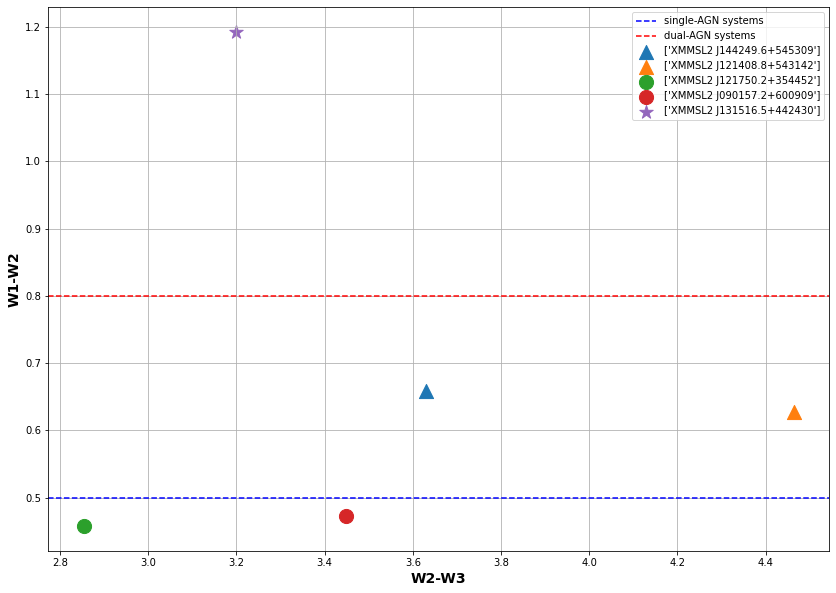

In [17]:
#color diagram
#W1_W2
W12_a = XMMSL2_data[mask]['ALLW_W1mag'][a] - XMMSL2_data[mask]['ALLW_W2mag'][a]
W12_b = XMMSL2_data[mask2]['ALLW_W1mag'][b] - XMMSL2_data[mask2]['ALLW_W2mag'][b]
W12_c = XMMSL2_data[mask2]['ALLW_W1mag'][c] - XMMSL2_data[mask2]['ALLW_W2mag'][c]
W12_d = XMMSL2_data[mask2]['ALLW_W1mag'][d] - XMMSL2_data[mask2]['ALLW_W2mag'][d]
W12_e = XMMSL2_data[mask2]['ALLW_W1mag'][e] - XMMSL2_data[mask2]['ALLW_W2mag'][e]

#W2_W3
W23_a = XMMSL2_data[mask]['ALLW_W2mag'][a] - XMMSL2_data[mask]['ALLW_W3mag'][a]
W23_b = XMMSL2_data[mask2]['ALLW_W2mag'][b] - XMMSL2_data[mask2]['ALLW_W3mag'][b]
W23_c = XMMSL2_data[mask2]['ALLW_W2mag'][c] - XMMSL2_data[mask2]['ALLW_W3mag'][c]
W23_d = XMMSL2_data[mask2]['ALLW_W2mag'][d] - XMMSL2_data[mask2]['ALLW_W3mag'][d]
W23_e = XMMSL2_data[mask2]['ALLW_W2mag'][e] - XMMSL2_data[mask2]['ALLW_W3mag'][e]

plt.scatter(W23_a, W12_a, marker='^', s=200, label=XMMSL2_data[mask]['XMMSL2_IAU_NAME'][a])
plt.scatter(W23_b, W12_b,  marker='^', s=200, label=XMMSL2_data[mask2]['XMMSL2_IAU_NAME'][b])
plt.scatter(W23_c, W12_c,  marker='o', s=200, label=XMMSL2_data[mask2]['XMMSL2_IAU_NAME'][c])
plt.scatter(W23_d, W12_d, marker='o', s=200, label=XMMSL2_data[mask2]['XMMSL2_IAU_NAME'][d])
plt.scatter(W23_e, W12_e,  marker='*', s=200, label=XMMSL2_data[mask2]['XMMSL2_IAU_NAME'][e])

plt.axhline(0.5, ls='--', c='blue', label='single-AGN systems') #
plt.axhline(0.8, ls='--', c='red', label='dual-AGN systems') #
plt.xlabel("W2-W3")
plt.ylabel("W1-W2")
plt.legend()
plt.grid();

In [18]:
print(XMMSL2_data[mask2]['SDSS_ID'][e], XMMSL2_data[mask2]['XMMSL2_IAU_NAME'][e], 
          XMMSL2_data[mask2]['PLATE_BEST'][e], XMMSL2_data[mask2]['MJD_BEST'][e], XMMSL2_data[mask2]['FIBERID_BEST'][c],
          XMMSL2_data[mask2]['SDSS_RA'][e], XMMSL2_data[mask2]['SDSS_DEC'][e], XMMSL2_data[mask2]['DR16_Z'][c],
     W12_e, W23_e)

[43] ['XMMSL2 J131516.5+442430'] [1376] [53089] [860] [198.82193888] [44.40710888] [0.0877616] [1.1919994] [3.1990004]


Testing data from SDSS/SPIDERS using the 2RXS sample. 
* Official SDSS-DR16 Value Added Catalogues: https://data.sdss.org/sas/dr16/eboss/spiders/analysis/VAC_SPIDERS_2RXS_DR16.fits
* Official data model, description of the columns: https://data.sdss.org/datamodel/files/SPIDERS_ANALYSIS/VAC_spiders_2RXS_DR16.html

Multi-wavelength characterization of the ROSAT 2RXS Survey point-like sources (Boller et al. 2016) over the DR16+SEQUELS footprints. We provide information about X-ray properties of the sources, as well as their Gaia DR2 optical counterparts, FIRST radio counterparts and AllWISE IR counterparts. The counterparts are identified first in the All-WISE IR catalog via a Bayesian cross-matching algorithm, NWAY ((Salvato et al 2018)). We complement this with dedicated visual inspection of the SDSS spectra, providing accurate redshift estimates (with objective confidence levels) and source classification, beyond the standard eBOSS pipeline results. 

Information on obtaining FITS table data: https://docs.astropy.org/en/stable/io/fits/usage/table.html

In [19]:
RXS_hdu=fits.open('VAC_SPIDERS_2RXS_DR16.fits')
RXS_data = RXS_hdu[1].data #image data
RXS_head = RXS_hdu[1].header #header data

In [20]:
RXS_head

XTENSION= 'BINTABLE'           / binary table extension                         
BITPIX  =                    8 / 8-bit bytes                                    
NAXIS   =                    2 / 2-dimensional table                            
NAXIS1  =                  587 / width of table in bytes                        
NAXIS2  =                21288 / number of rows in table                        
PCOUNT  =                    0 / size of special data area                      
GCOUNT  =                    1 / one data group                                 
TFIELDS =                  108 / number of columns                              
EXTNAME = 'Joined  '           / table name                                     
TTYPE1  = 'RXS_IAU_NAME'       / label for column 1                             
TFORM1  = '16A     '           / format for column 1                            
TTYPE2  = 'RXS_ExiML'          / label for column 2                             
TFORM2  = 'D       '        

In [21]:
#masked array
mask3 = np.zeros(np.shape(RXS_data), dtype='bool')
mask4 = np.zeros(np.shape(RXS_data), dtype='bool')

for i in range(len(RXS_data['CLASS_BEST'])):
    if RXS_data['CLASS_BEST'][i]  == 'NLAGN':
        mask3[i] = 1
        if RXS_data['DR16_z'][i] <=0.2:
            mask3[i] = 1
    if RXS_data['CLASS_BEST'][i]  == 'GALAXY':
        mask4[i] = 1
        if RXS_data['DR16_z'][i] <= 0.01:
            mask4[i] = 1

print(np.sum(mask3))
print(np.sum(mask4))

200
1885


In [22]:
#NLAGN targets for 2RXS
for i in range(len((RXS_data[mask3]))):
    print(RXS_data[mask3]['SDSS_ID'][i], RXS_data[mask3]['RXS_IAU_NAME'][i], 
          RXS_data[mask3]['PLATE_BEST'][i], RXS_data[mask3]['MJD_BEST'][i], RXS_data[mask3]['FIBERID_BEST'][i],
          RXS_data[mask3]['SDSS_RA'][i], RXS_data[mask3]['SDSS_DEC'][i], RXS_data[mask3]['DR16_Z'][i])

180 J093500.1+591058 452 51911 456 143.74632549208246 59.18161586005581 0.12544274
99 J105750.0+594704 561 52295 17 164.44866344228808 59.787009654391966 0.15946397
50 J082237.2+541909 1782 53299 170 125.65356987441656 54.31013958251198 0.08626459
203 J093748.7+585509 453 51915 310 144.45773624568898 58.922953105579374 0.13230318
114 J095624.1+564810 557 52253 72 149.09865849029813 56.80175240074452 0.07437419
155 J103926.3+562124 948 52428 259 159.8697499628521 56.34947899543254 0.07480073
251 J104617.5+555620 906 52368 535 161.57796178590064 55.94135478849651 0.19983466
137 J103249.2+545705 905 52643 481 158.20853255437845 54.94912910339635 0.11866621
339 J105553.2+543418 1011 52652 325 163.97309339640697 54.57148109845817 0.30987963
73 J102953.6+541135 905 52643 272 157.47243546856578 54.19369148982284 0.2299495
100 J111132.4+585247 950 52378 548 167.8788157688494 58.879649005958235 0.15857135
123 J114109.8+571819 1310 53033 558 175.28377511080143 57.303525788848546 0.13127853
59 J1

129 J150801.5+462212 1050 52721 396 227.00560807366975 46.3668545418671 0.094589725
97 J151004.8+453842 1050 52721 267 227.52233039574162 45.6440361009051 0.18417262
100 J151404.2+433739 1677 53148 518 228.52515428054676 43.63059505266675 0.2084193
65 J153441.4+462101 1332 52781 473 233.6726446994124 46.34536847182423 0.25196436
201 J153557.2+432532 1052 52466 519 233.9916596990115 43.428923879535084 0.19286765
16 J154129.1+432246 1052 52466 640 235.36723032260306 43.38045114912027 0.20077167
155 J153446.2+423540 1052 52466 255 233.69429518336443 42.59357469176135 0.07292306
144 J155523.4+421140 1334 52764 141 238.82799882255387 42.1900380946811 0.26748577
234 J162859.6+470438 624 52377 620 247.24685992320616 47.07854556270749 0.23389395
277 J161046.5+423056 1170 52756 199 242.69407826138467 42.512181362478366 0.13557985
125 J163323.2+471852 627 52144 408 248.34825671532786 47.31637573174901 0.11576096
133 J164840.1+425545 631 52079 325 252.167303516772 42.92990694511925 0.12891638
140

276 J234106.8+001841 385 51783 487 355.27872702986605 0.30925511192689337 0.27671984
366 J235545.1+000956 685 52203 322 358.9439045097767 0.16898686225288964 0.28340286


In [23]:
#GALAXY targets for 2RXS
for i in range(len((RXS_data[mask4]))):
    print(RXS_data[mask4]['SDSS_ID'][i], RXS_data[mask4]['RXS_IAU_NAME'][i], 
          RXS_data[mask4]['PLATE_BEST'][i], RXS_data[mask4]['MJD_BEST'][i], RXS_data[mask4]['FIBERID_BEST'][i],
          RXS_data[mask4]['SDSS_RA'][i], RXS_data[mask4]['SDSS_DEC'][i], RXS_data[mask4]['DR16_Z'][i])

370 J084551.4+600909 5709 56571 353 131.46473759355217 60.14768469635278 0.5654447
418 J084610.8+593409 1785 54439 393 131.5252248886287 59.57256785586417 0.32588843
131 J102319.2+594811 559 52316 456 155.8367591243693 59.81096212278865 0.19886383
261 J104625.4+593708 561 52295 205 161.60632464981148 59.62689616971611 0.22815754
276 J121436.1+600017 955 52409 200 183.66024054590775 59.99603125472863 0.060303453
109 J121517.4+595508 955 52409 167 183.80251440637497 59.9159901692296 0.060865354
84 J120132.4+594111 8237 58162 752 180.39090900361597 59.677486759780315 0.15979329
511 J115327.0+594001 8237 58162 548 178.36856354917563 59.67738903386209 0.35602874
243 J125930.9+600405 957 52398 547 194.88763857209608 60.06997875077312 0.34559315
175 J124719.5+591257 8235 58191 930 191.82551830597615 59.218862851541125 0.14947097
200 J133645.9+602051 6816 56444 404 204.19644513816502 60.34683166313826 0.32091865
325 J133406.2+592525 8212 58171 763 203.51299815749496 59.42968184531367 0.3231491

597 J115204.9+585404 7091 56658 641 177.9895343498224 58.90577159544358 0.6017303
163 J120816.9+585035 1314 53050 443 182.06561320141086 58.84360377597447 0.13572857
237 J114225.8+583215 7099 56666 64 175.60323914131712 58.53481493632204 0.32203305
235 J120158.8+580227 1314 53050 385 180.49691139549935 58.04819244424107 0.10600007
587 J120116.1+575838 8237 58162 247 180.31550415190327 57.975864965900044 0.4298663
505 J121802.3+574508 8236 58500 405 184.49674830581165 57.758856510639966 0.21331817
216 J115645.0+565710 1312 52781 70 179.1849659588387 56.94417552816182 0.20273039
108 J120012.3+561410 1313 52790 90 180.03699725689506 56.24169038785485 0.063125364
98 J115205.2+554820 8230 57430 965 178.0243516827344 55.80676430005506 0.13873492
413 J114727.1+554534 6839 56425 580 176.88724274884555 55.75946082269642 0.311063
202 J120237.9+554146 1018 52672 407 180.65438070791492 55.688682001548706 0.3290376
335 J114228.3+552144 1015 52734 620 175.61677043299804 55.36335351646374 0.06860612


101 J152720.2+563837 2883 54525 428 231.83180571306983 56.64414948671147 0.1775246
241 J152511.8+562615 8421 58223 666 231.30416818552996 56.43881633313641 0.29596823
208 J154517.2+555141 617 52072 173 236.36080172667505 55.86271049232261 0.14825372
80 J153231.8+553801 614 53437 516 233.13433471893595 55.63054425024712 0.14985752
296 J152529.5+552642 8421 58223 683 231.37366073690634 55.444479219036715 0.16800435
300 J153302.8+551648 6708 56452 550 233.26006466802926 55.269980088807635 0.30244535
71 J153704.8+551549 616 52442 364 234.26735316535854 55.26405392055756 0.0022496022
378 J155721.5+550206 8413 57897 692 239.3398612905601 55.03093404661554 0.5738382
127 J155722.6+544013 619 52056 158 239.33912809603163 54.67109129283051 0.046938766
216 J154544.6+544305 616 52442 618 236.44341084342642 54.7154820215311 0.10945836
145 J152347.5+541718 794 52376 550 230.94583783347537 54.28901796838995 0.15961245
268 J154548.7+540735 8419 58249 173 236.44409171760097 54.13073979752541 0.26628172

206 J105250.2+491939 876 52669 125 163.20840198236272 49.324622594335466 0.29928702
192 J110537.3+483445 964 52646 493 166.39719229248703 48.57823064744121 0.111164756
69 J110353.0+481531 7380 56753 118 165.98246531477795 48.26978173424539 0.17130458
210 J103836.4+475223 962 52620 414 159.64361446970054 47.86959601213205 0.12297883
178 J110953.2+512137 878 52353 261 167.4594705265236 51.363344756804906 0.33708063
684 J111040.0+504223 6692 56390 583 167.66101306205763 50.70340885233648 0.4519833
226 J111134.7+500641 878 52353 289 167.89786359534827 50.107816608074515 0.38763452
149 J111523.7+495641 965 52438 362 168.84649621203036 49.944683777274605 0.3114884
131 J112202.1+494526 965 52438 571 170.50335257721247 49.759995080182236 0.11492921
202 J113054.2+494349 966 52642 485 172.73349479380497 49.730586005688295 0.16089165
219 J113533.6+491540 967 52636 227 173.8747771012658 49.2718834760486 0.13175201
13 J113448.6+490436 966 52642 120 173.70539432689623 49.077634975877544 0.03333502
6

286 J151357.4+524737 8394 57865 356 228.49026705444925 52.79922902583297 0.7761989
72 J152310.9+515917 8394 57865 44 230.80097526738086 51.98778575961545 0.11771648
389 J153341.8+514909 8420 58197 204 233.40874192257786 51.81663966639024 0.15768178
270 J151957.4+511856 1166 52751 328 229.99150459599 51.31308237873651 0.07516064
198 J153335.3+510947 8407 57839 570 233.39401281757472 51.165619969034964 0.2392197
180 J151002.7+504906 1165 52703 218 227.51064166839433 50.81772461170662 0.063373014
225 J151549.8+491938 6727 56369 72 228.96978314011227 49.33178054941095 0.2730087
916 J152115.3+485847 8431 57482 976 230.31920747277871 48.99097066340525 0.712976
29 J152053.2+484015 1330 52822 31 230.2177013374391 48.66069564375832 0.07384337
523 J153211.5+482023 8430 57488 146 233.04820335566347 48.34031714797912 0.99046093
471 J150641.3+481100 6733 56369 889 226.6605444271061 48.18657363032904 0.5658004
704 J154437.4+532139 8414 57846 609 236.15215307940457 53.357068116046825 0.76632845
258 J

71 J102957.9+431418 1429 52990 132 157.49068733498672 43.24189705676879 0.0853158
156 J102028.6+424012 1358 52994 132 155.1179261906271 42.661643526044706 0.13531782
91 J104702.6+474642 962 52620 629 161.76744847712752 47.77796891030007 0.14582759
44 J104104.9+472624 6657 56366 747 160.27432696838338 47.43368189462398 0.23715809
177 J105136.0+464441 6664 56383 656 162.88924902406777 46.73630855490959 0.29574248
50 J104544.5+462914 1434 53053 364 161.44397193427454 46.48431992921101 0.05379123
48 J103705.6+461043 962 52620 244 159.27338114219918 46.18658266642466 0.1806007
126 J105940.8+455443 1436 53054 486 164.94450499792276 45.902684716956436 0.1787768
90 J105130.6+452802 1434 53053 514 162.88177164258445 45.46247477865432 0.0860698
119 J103635.6+450745 1431 52992 432 159.1393640728175 45.13373166361344 0.18168257
313 J103701.5+445159 1431 52992 465 159.2566230680136 44.86543499462268 0.12701683
194 J103649.7+445012 1429 52990 610 159.21016279450782 44.83670612894081 0.12627506
116 J

156 J142436.4+434736 1395 52825 418 216.15838932918257 43.79189472431411 0.10195254
184 J140450.3+434412 1467 53115 173 211.18910075217337 43.7433093558036 0.13558857
198 J142840.0+434114 1395 52825 573 217.17178112040202 43.69285296779548 0.21361114
683 J141110.7+434103 1394 53108 356 212.803412129731 43.68390793016459 0.30639353
175 J141342.7+433940 6055 56102 130 213.4321939814513 43.662508860691666 0.08932599
222 J142924.2+432517 1395 52825 504 217.35347035507078 43.43367940865408 0.12981026
156 J145604.4+472344 1049 52751 392 224.0169864051636 47.395037161750295 0.085045435
142 J145802.2+465753 8489 57483 926 224.51108522399255 46.96238778893963 0.43999588
284 J145233.9+461734 1675 53466 599 223.14233173839045 46.2912453178771 0.25653458
236 J145317.5+460145 6737 56365 316 223.30129712904798 46.029912323492375 0.22936684
204 J143728.4+455526 1674 53464 125 219.3643600495268 45.923627767161356 0.108622774
118 J143641.6+452734 8491 57488 372 219.18008149146178 45.46493269790465 0.24

460 J075633.4+370710 757 52238 346 119.13814314662389 37.123045930209244 0.08409163
913 J075800.9+364154 9356 57809 619 119.50622882679414 36.694258133108626 0.4400592
270 J082814.6+415400 761 54524 113 127.05917507486006 41.89775248727786 0.22599187
39 J084216.2+410609 895 52581 38 130.56134158883458 41.10562155452356 0.06842642
387 J082556.4+401403 8827 57444 620 126.48031619930943 40.22568755829861 0.406084
450 J082207.0+400812 9361 58055 912 125.52621374047891 40.15023389731873 0.26168492
316 J083540.4+395649 895 52581 54 128.91824487124455 39.94305973953882 0.09029563
447 J082355.2+394748 8827 57444 550 125.98175799393691 39.796558015177865 0.49997765
547 J082637.5+385613 8827 57444 388 126.65754093980414 38.9341542947163 0.3650668
616 J083341.7+385503 828 52317 272 128.4156494981871 38.921687392666485 0.352568
633 J083605.2+383253 3764 55514 287 129.02346215955123 38.55370848907805 0.54124826
957 J083533.8+365157 8858 57450 270 128.89002134640822 36.854009375396295 0.29630956
646

161 J113005.1+363825 2036 53446 281 172.5132669524897 36.637210716811055 0.063731104
266 J115607.9+420156 1447 53120 159 179.02413853177154 42.02393124710107 0.24515069
5 J115749.2+415603 1447 53120 101 179.472728596045 41.93715282267055 0.048261017
92 J114824.8+402127 1970 53386 471 177.10279353055859 40.36039741368142 0.1752749
196 J122719.6+412954 1452 53112 84 186.84659542779713 41.493958508955615 0.21987551
204 J121005.1+412902 6634 56367 110 182.52809645924987 41.48114191107046 0.23818281
171 J122348.1+410625 1986 53475 402 185.95117142754572 41.105876057740666 0.40638274
164 J122452.7+405048 1986 53475 459 186.22021003349488 40.838661389460725 0.38821986
276 J122421.0+404215 1986 53475 511 186.08686638749714 40.701684362781094 0.38585934
131 J121829.2+401239 1995 53415 26 184.6224313572047 40.207930444498174 0.13336156
61 J120810.0+400532 1976 53401 38 182.04125385810153 40.09467639832559 0.093741424
141 J120512.2+392051 1976 53401 11 181.29321038870398 39.34672303881955 0.03711

282 J143848.4+372144 1382 53115 462 219.69550755684372 37.3644728254072 0.25968364
166 J142139.6+371742 10756 58226 776 215.4188136921298 37.29163633251508 0.16324948
299 J151142.5+414959 6054 56089 989 227.92827977416096 41.839353026454155 0.37103024
305 J145033.0+412751 8498 57105 864 222.65271117601742 41.462047879269996 0.33683422
227 J145820.1+412129 6053 56091 58 224.5865411328066 41.35054512865565 0.17646277
355 J150855.6+405549 1292 52736 346 227.23685424750715 40.92382959521959 0.46785265
178 J150543.7+403545 11649 58514 564 226.4292582338058 40.59838198430709 0.44247591
303 J150605.7+403207 6054 56089 250 226.51951019174214 40.54041492913213 0.34251824
657 J150227.0+394728 1398 53146 517 225.62062200793076 39.79109095876886 0.56070524
379 J145635.8+385216 1351 52790 523 224.14297403636743 38.87234841793989 0.3433014
637 J150750.7+380914 10745 58277 873 226.95769416367273 38.15611519936125 0.67753524
181 J145833.8+380007 10748 58224 970 224.63876009652267 37.99833115418731 0.1

615 J172740.1+364110 10723 58287 792 261.92418365736705 36.686465490659415 0.14714551
567 J002011.6+345217 7131 56570 200 5.0549911314831775 34.86924596859138 0.263961
404 J002338.1+343700 7743 58107 218 5.918913305922672 34.61641379159101 0.25674883
460 J001554.4+334127 7126 56568 34 3.9832134622095055 33.69539555541187 0.29872078
280 J000801.5+322214 7748 58396 138 2.0065937856259666 32.36951008211315 0.081354246
558 J000855.2+321137 7127 56566 851 2.237721071289684 32.199348295975966 0.4754174
417 J002834.9+354502 7132 56565 726 7.123998409829653 35.74112598826702 0.07782394
587 J004116.2+321044 7716 58097 403 10.316392874055055 32.18541905347981 0.6319495
297 J010645.6+350023 6595 56569 992 16.697176275213963 35.00970582962034 0.156912
781 J005958.7+345613 7720 58101 787 14.98109817549755 34.94259598140771 0.22343412
320 J005611.8+344856 6874 56550 940 14.045686852426797 34.817411681787 0.15759638
435 J005921.3+335945 6595 56569 336 14.837332138461989 33.99542992979463 0.29066488
6

263 J101940.8+322811 10273 58466 419 154.90614017826246 32.46822017849902 0.19655952
140 J100634.3+315856 1952 53378 270 151.64282422426075 31.98346262953951 0.092519075
128 J101020.6+314903 6461 56329 318 152.58010900359272 31.80900738128721 0.30494493
206 J101507.2+313408 1956 53437 364 153.7789589699957 31.561323899311883 0.12395256
173 J101833.4+312850 1956 53437 476 154.6417451686469 31.476125130865586 0.16137627
208 J101428.1+310416 1953 53358 578 153.61899820597722 31.065932041061746 0.2474775
246 J104923.4+354421 2090 53463 162 162.34745422418845 35.74471363914976 0.32241756
207 J104312.1+342755 2025 53431 423 160.7844308752914 34.456754112682475 0.36194095
361 J104527.6+333411 10270 58488 394 161.36697566731138 33.5718278179824 0.6683676
296 J105352.5+330254 6442 56369 521 163.4709993210925 33.050088769414906 0.61149824
173 J103453.1+325307 10271 58497 276 158.72456710309734 32.88894045211082 0.16931483
208 J103841.8+321701 10271 58497 129 159.68453011619644 32.28984869884647 

606 J141435.9+363250 3855 55268 925 213.65107037220088 36.54685991892035 0.60279006
151 J141401.3+361506 10760 58224 24 213.49801311643876 36.261596681266994 0.3380619
234 J141821.4+355415 10756 58226 363 214.59072282575767 35.89873140798315 0.39188752
209 J141957.4+354157 1644 53144 351 214.9941242613222 35.70386477548389 0.1720199
275 J142058.9+343745 10758 58220 139 215.24149237707485 34.63561018291193 0.26672077
436 J142036.0+342953 10758 58220 132 215.13840604180126 34.4898778920232 0.8710296
100 J141410.0+343056 10758 58220 390 213.53869495585013 34.51601692439987 0.27497226
60 J143550.8+363238 1382 53115 228 218.95897027813305 36.54322241008046 0.0136541845
368 J144411.4+355304 10754 58224 971 221.05017050805236 35.88757389116781 0.19281526
357 J143457.1+354401 1645 53172 533 218.7508916389247 35.735418835605984 0.20293684
47 J143623.8+353702 10754 58224 618 219.09945675177897 35.61662532458354 0.39162102
67 J142946.6+353431 1645 53172 323 217.44858983618707 35.57430288798779 0.

195 J234420.1+333354 7760 58080 872 356.0893957873249 33.56509383141688 0.09135346
181 J234726.2+333043 7759 58401 187 356.8662190364855 33.50788033553793 0.09255534
339 J235406.4+331034 7751 58081 762 358.5176067335824 33.16773908968349 0.1821646
220 J000010.9+300555 7749 58073 375 0.04550106964279621 30.102297070763044 0.26063585
392 J002029.9+291337 7742 58076 325 5.123986517807339 29.231407989316505 0.09457394
151 J001052.1+290936 7746 58074 213 2.7224274329323634 29.16104546456795 0.32939202
627 J000658.7+285129 7134 56566 86 1.7327948345252366 28.872404556344655 0.20382401
34 J002044.6+283811 7742 58076 248 5.177116728783972 28.634522036847432 0.09404994
479 J000242.1+252835 6513 56543 954 0.6779582177923089 25.477874185634008 0.38541067
291 J004127.8+305125 7718 57362 547 10.365843929828827 30.857334454430923 0.18352714
524 J003456.8+300121 6252 56248 563 8.748949133135966 30.02101827545318 0.23053768
276 J003153.8+293400 7714 57363 348 7.977383618002307 29.572322373743642 0.050

166 J093707.8+270456 1944 53385 207 144.28012971370794 27.079528969922173 0.14325146
96 J093922.9+264405 11704 58514 770 144.84336260749978 26.733964557355055 0.43313262
151 J093732.0+260241 2294 54524 636 144.37635756484332 26.042261939181294 0.16219445
42 J093900.5+253005 2297 53738 295 144.75405008391527 25.5010396519667 0.17737521
206 J095919.9+302333 1950 53436 445 149.83536896932398 30.379941194028792 0.20332488
121 J100256.5+294938 5800 56279 30 150.73117158535038 29.826905319587933 0.08703266
510 J100715.7+294530 11380 58462 46 151.81237777542924 29.7629777374653 0.3184447
267 J100250.5+293054 11380 58462 245 150.71095038798722 29.513432421139726 0.20406465
123 J101007.3+292818 1953 53358 70 152.5342731072662 29.47243797993584 0.25350803
148 J100459.5+291227 1950 53436 35 151.24979789386498 29.211106291854485 0.37996975
374 J100426.4+291049 1950 53436 25 151.11195017360208 29.18637604991781 0.37559128
192 J101623.7+284918 2351 53786 317 154.11611994994027 28.822633963685607 0.2

128 J012141.6+200548 7629 56988 608 20.425667501850455 20.09770294255434 0.17667039
166 J014558.2+213454 7633 56931 503 26.49168436742997 21.584470508274304 0.27458888
100 J014651.2+212346 7633 56931 527 26.711629939429997 21.403682922112477 0.12658617
164 J014403.6+205457 7634 56935 110 26.022061299243774 20.923039075712065 0.2773422
445 J014222.3+203223 7634 56935 176 25.600649946729618 20.546206100630158 0.2023477
248 J014723.4+202656 7633 56931 469 26.85646755640215 20.452778152024543 0.3896952
41 J015810.1+251538 5697 55944 184 29.54146612948631 25.26137094562846 0.15821226
379 J020752.1+242149 7692 57064 10 31.965902497764205 24.377976300673037 0.31311226
688 J072927.6+243621 4464 55866 486 112.36590654784659 24.60655748196345 0.16138938
62 J073825.0+241301 4470 55587 582 114.60495361419488 24.218360319121185 0.041722056
577 J074913.8+231310 11103 58488 934 117.30844343949202 23.221355802065293 0.1740745
504 J074557.8+222654 11103 58488 268 116.49659231103294 22.44747530355522 0.

128 J001807.5+084845 4538 55860 476 4.534224159425264 8.820480148745805 0.23568246
188 J004330.4+123947 11042 58462 345 10.87418664847354 12.66652700631104 0.07893018
221 J003704.6+090930 4540 55863 34 9.278507647290382 9.156702924042413 0.24939582
268 J004143.6+083318 11047 58424 360 10.43018134668381 8.555136634970582 0.5950822
147 J004652.9+123953 11042 58462 143 11.7214202605781 12.661262521627132 0.42581606
96 J004528.1+100832 11047 58424 879 11.360144313648675 10.150286439108969 0.18241589
82 J010056.3+093101 11055 58429 999 15.231779794167608 9.522481297881646 0.08015593
224 J004533.5+092315 11047 58424 858 11.398572847651906 9.388015497358285 0.30603784
646 J012926.3+131114 425 51898 251 22.35905223618215 13.186860498869699 0.33392256
714 J012738.7+112304 11069 58456 430 21.914515209154274 11.38575756079586 0.41532043
696 J011150.2+095131 4551 55569 883 17.956745677155595 9.843876711365054 0.6165557
113 J010925.2+094444 4551 55569 764 17.35529357718508 9.741795771649826 0.21829

472 J215206.1+031648 4090 55500 390 328.02730936407085 3.277461597579337 0.25753042
613 J222913.3+043446 11340 58433 256 337.30177710219454 4.589691624378843 0.18484071
992 J222727.0+041234 11340 58433 321 336.86237984386315 4.21588300110098 1.0982056
260 J222822.1+031946 4320 55894 174 337.0932297965789 3.328864216642062 0.16624284
761 J222428.6+030742 11342 58425 235 336.11238293718526 3.1223353511795082 0.29609087
925 J221156.8+025905 11341 58428 355 332.98636647366317 2.9785718905065117 0.42727506
281 J223443.1+055033 11304 58448 440 338.69603511010376 5.843473546610046 0.16670974
465 J223408.9+055004 11304 58448 536 338.545019962907 5.83139254019776 0.15860422
326 J231245.8+052101 11295 58456 505 348.1949769523856 5.3571716886379885 0.17892069
228 J230309.2+042022 4289 55856 687 345.78238319860986 4.34447558686205 0.17838037
254 J231134.3+033819 4287 55483 394 347.88842203872224 3.634360797860179 0.24662429
538 J230247.4+033734 11303 58428 770 345.6973883973186 3.617497774859577 0

138 J015631.2+015105 7836 57278 399 29.130723170013084 1.8512985062282996 0.10243487
17 J015242.0+010034 4232 55447 947 28.174845847387985 1.0070924148829121 0.22970901
173 J020747.2+005237 404 51812 561 31.95858648317386 0.8730759107631709 0.04105189
260 J015637.0+005037 403 51871 418 29.16153868369632 0.8435760395181917 0.21755363
16 J020106.3+003400 403 51871 631 30.2757542623797 0.5666983913427565 0.2984806
624 J020538.0+002627 702 52178 398 31.40389000976738 0.4393540913884777 0.40925065
311 J021132.0+002338 1073 52649 383 32.87553010512397 0.39829192081009096 0.2892398
811 J020613.2+001933 4235 55451 613 31.54526127521285 0.3190127526115652 0.682616
211 J015752.6-003636 1505 52941 184 29.468423554120307 -0.6148711833325738 0.18983507
719 J020204.8-005325 701 52179 137 30.52223157885254 -0.8847065658826455 0.34405243
326 J020236.6-010648 404 51812 246 30.653902706137394 -1.1066231915607054 0.101709396
92 J020622.6-011755 4347 55830 872 31.595232065198033 -1.308773536161517 0.19845

167 J021446.9-035627 7885 57336 115 33.69355302456853 -3.9418687858984116 0.14014897
48 J020332.5-042038 7238 56660 584 30.87741255039282 -4.338691190997517 0.17498954
264 J021441.6-043430 7885 57336 93 33.671223105955185 -4.567354769262685 0.1392409
59 J022536.2-030928 4387 55534 782 36.39593805460159 -3.1639069285112917 0.14068744
123 J022542.7-031207 7881 57282 528 36.428830092553575 -3.204630154121512 0.14142439
121 J023052.3-042054 4387 55534 9 37.72083980663053 -4.347797528669419 0.14082779
153 J022057.0-042614 7883 57331 222 35.2382231311195 -4.436465947168474 0.3149756
276 J023137.3-045352 4388 55536 871 37.907599514718186 -4.895360268096645 0.18479952
287 J024802.1-033210 7879 57359 706 42.010051838240166 -3.5338233601164992 0.19097567
571 J025402.2-035208 9310 57724 691 43.50661866962456 -3.8719303484046894 1.0621423


In [24]:
f = RXS_data[mask3]['RXS_IAU_NAME'] == 'J133819.1+481638'
print(RXS_data[mask3]['SDSS_ID'][f], RXS_data[mask3]['RXS_IAU_NAME'][f], 
          RXS_data[mask3]['PLATE_BEST'][f], RXS_data[mask3]['MJD_BEST'][f], RXS_data[mask3]['FIBERID_BEST'][f],
          RXS_data[mask3]['SDSS_RA'][f], RXS_data[mask3]['SDSS_DEC'][f], RXS_data[mask3]['DR16_Z'][f])

[76] ['J133819.1+481638'] [3003] [54845] [390] [204.57199881] [48.27561271] [0.02758319]


In [25]:
g = RXS_data[mask3]['RXS_IAU_NAME'] == 'J144248.3+545313'
print(RXS_data[mask3]['SDSS_ID'][g], RXS_data[mask3]['RXS_IAU_NAME'][g], 
          RXS_data[mask3]['PLATE_BEST'][g], RXS_data[mask3]['MJD_BEST'][g], RXS_data[mask3]['FIBERID_BEST'][g],
          RXS_data[mask3]['SDSS_RA'][g], RXS_data[mask3]['SDSS_DEC'][g], RXS_data[mask3]['DR16_Z'][g])

[12] ['J144248.3+545313'] [1162] [52668] [66] [220.71026376] [54.88572754] [0.12485466]


In [26]:
h = RXS_data[mask3]['RXS_IAU_NAME'] == 'J120413.1+481914'
print(RXS_data[mask3]['SDSS_ID'][h], RXS_data[mask3]['RXS_IAU_NAME'][h], 
          RXS_data[mask3]['PLATE_BEST'][h], RXS_data[mask3]['MJD_BEST'][h], RXS_data[mask3]['FIBERID_BEST'][h],
          RXS_data[mask3]['SDSS_RA'][h], RXS_data[mask3]['SDSS_DEC'][h], RXS_data[mask3]['DR16_Z'][h])

[120] ['J120413.1+481914'] [1449] [53116] [370] [181.05524908] [48.3191364] [0.11751968]


In [27]:
i = RXS_data[mask4]['RXS_IAU_NAME'] == 'J013037.9+131204'
print(RXS_data[mask4]['SDSS_ID'][i], RXS_data[mask4]['RXS_IAU_NAME'][i], 
          RXS_data[mask4]['PLATE_BEST'][i], RXS_data[mask4]['MJD_BEST'][i], RXS_data[mask4]['FIBERID_BEST'][i],
          RXS_data[mask4]['SDSS_RA'][i], RXS_data[mask4]['SDSS_DEC'][i], RXS_data[mask4]['DR16_Z'][i])

[170] ['J013037.9+131204'] [425] [51898] [216] [22.6573185] [13.21444407] [0.07217443]


In [28]:
j = RXS_data[mask4]['RXS_IAU_NAME'] == 'J095736.5+365604'
print(RXS_data[mask4]['SDSS_ID'][j], RXS_data[mask4]['RXS_IAU_NAME'][j], 
          RXS_data[mask4]['PLATE_BEST'][j], RXS_data[mask4]['MJD_BEST'][j], RXS_data[mask4]['FIBERID_BEST'][j],
          RXS_data[mask4]['SDSS_RA'][j], RXS_data[mask4]['SDSS_DEC'][j], RXS_data[mask4]['DR16_Z'][j])

[129] ['J095736.5+365604'] [1596] [52998] [476] [149.40217581] [36.94310281] [0.04060065]


In [29]:
k = RXS_data[mask4]['RXS_IAU_NAME'] == 'J140645.7+471634'
print(RXS_data[mask4]['SDSS_ID'][k], RXS_data[mask4]['RXS_IAU_NAME'][k], 
          RXS_data[mask4]['PLATE_BEST'][k], RXS_data[mask4]['MJD_BEST'][k], RXS_data[mask4]['FIBERID_BEST'][k],
          RXS_data[mask4]['SDSS_RA'][k], RXS_data[mask4]['SDSS_DEC'][k], RXS_data[mask4]['DR16_Z'][k])

[169] ['J140645.7+471634'] [1286] [52725] [426] [211.68509651] [47.26722455] [0.05986154]


In [30]:
l = RXS_data[mask4]['RXS_IAU_NAME'] == 'J140738.1+442859'
print(RXS_data[mask4]['SDSS_ID'][l], RXS_data[mask4]['RXS_IAU_NAME'][l], 
          RXS_data[mask4]['PLATE_BEST'][l], RXS_data[mask4]['MJD_BEST'][l], RXS_data[mask4]['FIBERID_BEST'][l],
          RXS_data[mask4]['SDSS_RA'][l], RXS_data[mask4]['SDSS_DEC'][l], RXS_data[mask4]['DR16_Z'][l])

[185] ['J140738.1+442859'] [6055] [56102] [400] [211.90599026] [44.48199539] [0.14301738]


In [31]:
m = RXS_data[mask4]['RXS_IAU_NAME'] == 'J103649.7+445012'
print(RXS_data[mask4]['SDSS_ID'][m], RXS_data[mask4]['RXS_IAU_NAME'][m], 
          RXS_data[mask4]['PLATE_BEST'][m], RXS_data[mask4]['MJD_BEST'][m], RXS_data[mask4]['FIBERID_BEST'][m],
          RXS_data[mask4]['SDSS_RA'][m], RXS_data[mask4]['SDSS_DEC'][m], RXS_data[mask4]['DR16_Z'][m])

[194] ['J103649.7+445012'] [1429] [52990] [610] [159.21016279] [44.83670613] [0.12627506]


In [32]:
n = RXS_data[mask4]['RXS_IAU_NAME'] == 'J091839.3+453037'
print(RXS_data[mask4]['SDSS_ID'][n], RXS_data[mask4]['RXS_IAU_NAME'][n], 
          RXS_data[mask4]['PLATE_BEST'][n], RXS_data[mask4]['MJD_BEST'][n], RXS_data[mask4]['FIBERID_BEST'][n],
          RXS_data[mask4]['SDSS_RA'][n], RXS_data[mask4]['SDSS_DEC'][n], RXS_data[mask4]['DR16_Z'][n])

[141] ['J091839.3+453037'] [833] [52314] [317] [139.66385278] [45.50565741] [0.19478297]


In [33]:
#color diagram
#W1_W2
W12_f = RXS_data[mask3]['ALLW_W1mag'][f] - RXS_data[mask3]['ALLW_W2mag'][f]
W12_g = RXS_data[mask3]['ALLW_W1mag'][g] - RXS_data[mask3]['ALLW_W2mag'][g]
W12_h = RXS_data[mask3]['ALLW_W1mag'][h] - RXS_data[mask3]['ALLW_W2mag'][h]
W12_i = RXS_data[mask4]['ALLW_W1mag'][i] - RXS_data[mask4]['ALLW_W2mag'][i]
W12_j = RXS_data[mask4]['ALLW_W1mag'][j] - RXS_data[mask4]['ALLW_W2mag'][j]
W12_k = RXS_data[mask4]['ALLW_W1mag'][k] - RXS_data[mask4]['ALLW_W2mag'][k]
W12_l = RXS_data[mask4]['ALLW_W1mag'][l] - RXS_data[mask4]['ALLW_W2mag'][l]
W12_m = RXS_data[mask4]['ALLW_W1mag'][m] - RXS_data[mask4]['ALLW_W2mag'][m]
W12_n = RXS_data[mask4]['ALLW_W1mag'][n] - RXS_data[mask4]['ALLW_W2mag'][n]


#W2_W3
W23_f = RXS_data[mask3]['ALLW_W2mag'][f] - RXS_data[mask3]['ALLW_W3mag'][f]
W23_g = RXS_data[mask3]['ALLW_W2mag'][g] - RXS_data[mask3]['ALLW_W3mag'][g]
W23_h = RXS_data[mask3]['ALLW_W2mag'][h] - RXS_data[mask3]['ALLW_W3mag'][h]
W23_i = RXS_data[mask4]['ALLW_W2mag'][i] - RXS_data[mask4]['ALLW_W3mag'][i]
W23_j = RXS_data[mask4]['ALLW_W2mag'][j] - RXS_data[mask4]['ALLW_W3mag'][j]
W23_k = RXS_data[mask4]['ALLW_W2mag'][k] - RXS_data[mask4]['ALLW_W3mag'][k]
W23_l = RXS_data[mask4]['ALLW_W2mag'][l] - RXS_data[mask4]['ALLW_W3mag'][l]
W23_m = RXS_data[mask4]['ALLW_W2mag'][m] - RXS_data[mask4]['ALLW_W3mag'][m]
W23_n = RXS_data[mask4]['ALLW_W2mag'][n] - RXS_data[mask4]['ALLW_W3mag'][n]

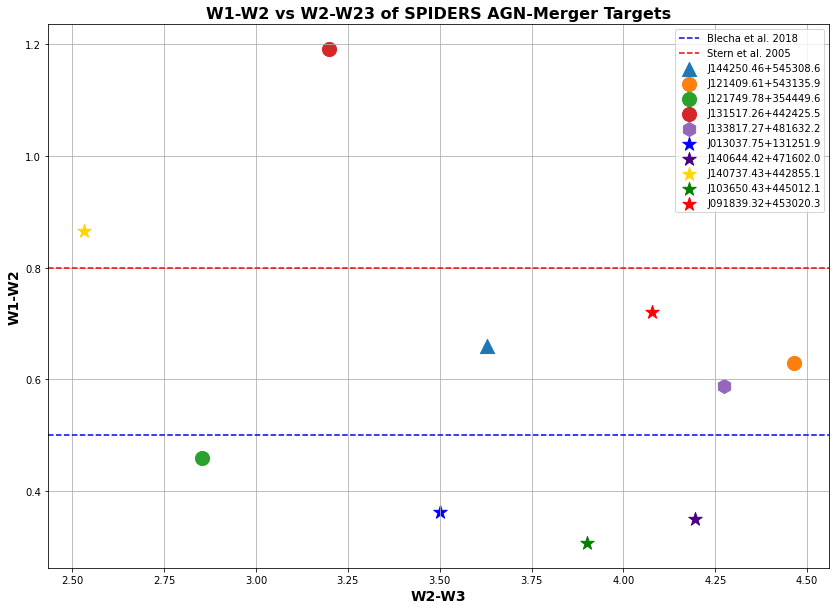

In [39]:
plt.scatter(W23_a, W12_a, marker='^', s=200, label='J144250.46+545308.6')
plt.scatter(W23_b, W12_b,  marker='o', s=200, label='J121409.61+543135.9')
plt.scatter(W23_c, W12_c,  marker='o', s=200, label='J121749.78+354449.6')
plt.scatter(W23_e, W12_e,  marker='o', s=200, label='J131517.26+442425.5')
plt.scatter(W23_f, W12_f, marker='h', s=200, label='J133817.27+481632.2')
plt.scatter(W23_i, W12_i, c='blue', marker='*', s=200, label='J013037.75+131251.9')
plt.scatter(W23_k, W12_k, c='indigo', marker='*', s=200, label='J140644.42+471602.0')
plt.scatter(W23_l, W12_l, c='gold', marker='*', s=200, label='J140737.43+442855.1')
plt.scatter(W23_m, W12_m, c='green', marker='*', s=200, label='J103650.43+445012.1')
plt.scatter(W23_n, W12_n, c='red', marker='*', s=200, label='J091839.32+453020.3')

plt.axhline(0.5, ls='--', c='blue', label='Blecha et al. 2018') #
plt.axhline(0.8, ls='--', c='red', label='Stern et al. 2005') #
plt.title("W1-W2 vs W2-W23 of SPIDERS AGN-Merger Targets")
plt.xlabel("W2-W3")
plt.ylabel("W1-W2")
plt.legend()
plt.grid()
plt.savefig('w1w2vsw2w3_results2.png');

Recreate information for a table of the following

In [41]:
print(XMMSL2_data[mask]['SDSS_ID'][a], XMMSL2_data[mask]['XMMSL2_IAU_NAME'][a], 
          XMMSL2_data[mask]['PLATE_BEST'][a], XMMSL2_data[mask]['MJD_BEST'][a], XMMSL2_data[mask]['FIBERID_BEST'][a],
          XMMSL2_data[mask]['SDSS_RA'][a], XMMSL2_data[mask]['SDSS_DEC'][a], XMMSL2_data[mask]['DR16_Z'][a],
     W12_a, W23_a, XMMSL2_data[mask]['XMMSL2_SCTS_B7'][a], XMMSL2_data[mask]['XMMSL2_FLUX_B7'][a])
print(XMMSL2_data[mask2]['SDSS_ID'][b], XMMSL2_data[mask2]['XMMSL2_IAU_NAME'][b], 
          XMMSL2_data[mask2]['PLATE_BEST'][b], XMMSL2_data[mask2]['MJD_BEST'][b], XMMSL2_data[mask2]['FIBERID_BEST'][b],
          XMMSL2_data[mask2]['SDSS_RA'][b], XMMSL2_data[mask2]['SDSS_DEC'][b], XMMSL2_data[mask2]['DR16_Z'][b],
     W12_b, W23_b, XMMSL2_data[mask2]['XMMSL2_SCTS_B7'][b], XMMSL2_data[mask2]['XMMSL2_FLUX_B7'][b])
print(XMMSL2_data[mask2]['SDSS_ID'][c], XMMSL2_data[mask2]['XMMSL2_IAU_NAME'][c], 
          XMMSL2_data[mask2]['PLATE_BEST'][c], XMMSL2_data[mask2]['MJD_BEST'][c], XMMSL2_data[mask2]['FIBERID_BEST'][c],
          XMMSL2_data[mask2]['SDSS_RA'][c], XMMSL2_data[mask2]['SDSS_DEC'][c], XMMSL2_data[mask2]['DR16_Z'][c],
     W12_c, W23_c, XMMSL2_data[mask2]['XMMSL2_SCTS_B7'][c], XMMSL2_data[mask2]['XMMSL2_FLUX_B7'][c])
print(XMMSL2_data[mask2]['SDSS_ID'][d], XMMSL2_data[mask2]['XMMSL2_IAU_NAME'][d], 
          XMMSL2_data[mask2]['PLATE_BEST'][d], XMMSL2_data[mask2]['MJD_BEST'][d], XMMSL2_data[mask2]['FIBERID_BEST'][d],
          XMMSL2_data[mask2]['SDSS_RA'][d], XMMSL2_data[mask2]['SDSS_DEC'][d], XMMSL2_data[mask2]['DR16_Z'][d],
     W12_d, W23_d, XMMSL2_data[mask2]['XMMSL2_SCTS_B7'][d], XMMSL2_data[mask2]['XMMSL2_FLUX_B7'][d])
print(XMMSL2_data[mask2]['SDSS_ID'][e], XMMSL2_data[mask2]['XMMSL2_IAU_NAME'][e], 
          XMMSL2_data[mask2]['PLATE_BEST'][e], XMMSL2_data[mask2]['MJD_BEST'][e], XMMSL2_data[mask2]['FIBERID_BEST'][e],
          XMMSL2_data[mask2]['SDSS_RA'][e], XMMSL2_data[mask2]['SDSS_DEC'][e], XMMSL2_data[mask2]['DR16_Z'][e],
     W12_e, W23_e, XMMSL2_data[mask2]['XMMSL2_SCTS_B7'][e], XMMSL2_data[mask2]['XMMSL2_FLUX_B7'][e])
print(RXS_data[mask3]['SDSS_ID'][f], RXS_data[mask3]['RXS_IAU_NAME'][f], 
          RXS_data[mask3]['PLATE_BEST'][f], RXS_data[mask3]['MJD_BEST'][f], RXS_data[mask3]['FIBERID_BEST'][f],
          RXS_data[mask3]['SDSS_RA'][f], RXS_data[mask3]['SDSS_DEC'][f], RXS_data[mask3]['DR16_Z'][f], W12_f, W23_f, 
      RXS_data[mask3]['RXS_Cts'][f], RXS_data[mask3]['RXS_SRC_FLUX'][f])
print(RXS_data[mask3]['SDSS_ID'][g], RXS_data[mask3]['RXS_IAU_NAME'][g], 
          RXS_data[mask3]['PLATE_BEST'][g], RXS_data[mask3]['MJD_BEST'][g], RXS_data[mask3]['FIBERID_BEST'][g],
          RXS_data[mask3]['SDSS_RA'][g], RXS_data[mask3]['SDSS_DEC'][g], RXS_data[mask3]['DR16_Z'][g], W12_g, W23_g,
     RXS_data[mask3]['RXS_Cts'][g], RXS_data[mask3]['RXS_SRC_FLUX'][g])
print(RXS_data[mask3]['SDSS_ID'][h], RXS_data[mask3]['RXS_IAU_NAME'][h], 
          RXS_data[mask3]['PLATE_BEST'][h], RXS_data[mask3]['MJD_BEST'][h], RXS_data[mask3]['FIBERID_BEST'][h],
          RXS_data[mask3]['SDSS_RA'][h], RXS_data[mask3]['SDSS_DEC'][h], RXS_data[mask3]['DR16_Z'][h], W12_h, W23_h,
     RXS_data[mask3]['RXS_Cts'][h], RXS_data[mask3]['RXS_SRC_FLUX'][h])
print(RXS_data[mask4]['SDSS_ID'][i], RXS_data[mask4]['RXS_IAU_NAME'][i], 
          RXS_data[mask4]['PLATE_BEST'][i], RXS_data[mask4]['MJD_BEST'][i], RXS_data[mask4]['FIBERID_BEST'][i],
          RXS_data[mask4]['SDSS_RA'][i], RXS_data[mask4]['SDSS_DEC'][i], RXS_data[mask4]['DR16_Z'][i], W12_i, W23_i,
     RXS_data[mask4]['RXS_Cts'][i], RXS_data[mask4]['RXS_SRC_FLUX'][i])
print(RXS_data[mask4]['SDSS_ID'][j], RXS_data[mask4]['RXS_IAU_NAME'][j], 
          RXS_data[mask4]['PLATE_BEST'][j], RXS_data[mask4]['MJD_BEST'][j], RXS_data[mask4]['FIBERID_BEST'][j],
          RXS_data[mask4]['SDSS_RA'][j], RXS_data[mask4]['SDSS_DEC'][j], RXS_data[mask4]['DR16_Z'][j], W12_j, W23_j,
     RXS_data[mask4]['RXS_Cts'][j], RXS_data[mask4]['RXS_SRC_FLUX'][j])
print(RXS_data[mask4]['SDSS_ID'][k], RXS_data[mask4]['RXS_IAU_NAME'][k], 
          RXS_data[mask4]['PLATE_BEST'][k], RXS_data[mask4]['MJD_BEST'][k], RXS_data[mask4]['FIBERID_BEST'][k],
          RXS_data[mask4]['SDSS_RA'][k], RXS_data[mask4]['SDSS_DEC'][k], RXS_data[mask4]['DR16_Z'][k], W12_k, W23_k, 
     RXS_data[mask4]['RXS_Cts'][k], RXS_data[mask4]['RXS_SRC_FLUX'][k])
print(RXS_data[mask4]['SDSS_ID'][l], RXS_data[mask4]['RXS_IAU_NAME'][l], 
          RXS_data[mask4]['PLATE_BEST'][l], RXS_data[mask4]['MJD_BEST'][l], RXS_data[mask4]['FIBERID_BEST'][l],
          RXS_data[mask4]['SDSS_RA'][l], RXS_data[mask4]['SDSS_DEC'][l], RXS_data[mask4]['DR16_Z'][l], W12_l, W23_l,
     RXS_data[mask4]['RXS_Cts'][l], RXS_data[mask4]['RXS_SRC_FLUX'][l])
print(RXS_data[mask4]['SDSS_ID'][m], RXS_data[mask4]['RXS_IAU_NAME'][m], 
          RXS_data[mask4]['PLATE_BEST'][m], RXS_data[mask4]['MJD_BEST'][m], RXS_data[mask4]['FIBERID_BEST'][m],
          RXS_data[mask4]['SDSS_RA'][m], RXS_data[mask4]['SDSS_DEC'][m], RXS_data[mask4]['DR16_Z'][m], W12_m, W23_m,
     RXS_data[mask4]['RXS_Cts'][m], RXS_data[mask4]['RXS_SRC_FLUX'][m])
print(RXS_data[mask4]['SDSS_ID'][n], RXS_data[mask4]['RXS_IAU_NAME'][n], 
          RXS_data[mask4]['PLATE_BEST'][n], RXS_data[mask4]['MJD_BEST'][n], RXS_data[mask4]['FIBERID_BEST'][n],
          RXS_data[mask4]['SDSS_RA'][n], RXS_data[mask4]['SDSS_DEC'][n], RXS_data[mask4]['DR16_Z'][n], W12_n, W23_n,
     RXS_data[mask4]['RXS_Cts'][n], RXS_data[mask4]['RXS_SRC_FLUX'][n])

[12] ['XMMSL2 J144249.6+545309'] [1162] [52668] [66] [220.71026376] [54.88572754] [0.12485466] [0.6590004] [3.6289997] [nan] [nan]
[14] ['XMMSL2 J121408.8+543142'] [1019] [52707] [261] [183.54006271] [54.52664625] [0.00817774] [0.62800026] [4.464] [nan] [nan]
[107] ['XMMSL2 J121750.2+354452'] [4613] [55591] [860] [184.45745824] [35.7471253] [0.0877616] [0.45800018] [2.854] [4.042545] [4.9185505]
[15] ['XMMSL2 J090157.2+600909'] [1785] [54439] [615] [135.49330947] [60.15172659] [0.01113352] [0.47299957] [3.448] [nan] [nan]
[43] ['XMMSL2 J131516.5+442430'] [1376] [53089] [350] [198.82193888] [44.40710888] [0.03552209] [1.1919994] [3.1990004] [4.044248] [8.771892]
[76] ['J133819.1+481638'] [3003] [54845] [390] [204.57199881] [48.27561271] [0.02758319] [0.5869999] [4.275] [29.23] [6.739484e-13]
[12] ['J144248.3+545313'] [1162] [52668] [66] [220.71026376] [54.88572754] [0.12485466] [0.6590004] [3.6289997] [33.33] [4.746232e-13]
[120] ['J120413.1+481914'] [1449] [53116] [370] [181.05524908] 

Calculating the Luminosity.

https://docs.astropy.org/en/stable/cosmology/

find the luminosity distance to redshift 4 by:
cosmo.luminosity_distance(4)  

1 Mpc = 3.08567758128E+24 cm

In [85]:
cosmo = FlatLambdaCDM(H0=68.0, Om0=0.31) #real universe
d_L = cosmo.luminosity_distance(float(RXS_data[mask4]['DR16_Z'][n]))*(3.08567758128e+24)
(4*np.pi)*(d_L**2)*(float(RXS_data[mask4]['RXS_SRC_FLUX'][n]))

<Quantity 4.69242524e+43 Mpc2>

In [71]:
cosmo.luminosity_distance(float(RXS_data[mask3]['DR16_Z'][f]))*(3.08567758128e+24)

<Quantity 3.83102238e+26 Mpc>

In [72]:
float(RXS_data[mask3]['RXS_SRC_FLUX'][f])

6.739484187737177e-13

In [48]:
t = RXS_data['CLASS_BEST']  == 'GALAXY'
z = RXS_data['RXS_IAU_NAME'] == 'J013037.9+131204'
RXS_data['SDSS_RA'][z]

array([22.6573185])

In [ ]:
RXS_data['PLATE_BEST'][t]

https://pandas.pydata.org/docs/user_guide/style.html
https://numpy.org/doc/stable/reference/generated/numpy.savetxt.html